# 综合项目实战Python数据分析：豆瓣电影分析系统
 ## ——基于爬虫、Panads、MatplotLib 等技术实现
## 1 数据收集篇
### 1.1 爬虫抓取豆瓣top250网页数据

先来看一下准备爬取的页面：
![](http://image.shenghaishxt.cn//20201113215832.png)

我们抓取排名、电影名、导演、主演、上映日期、制片国家/地区、类型，评分、评论数量、一句话评价以及电影链接，其中导演和主演分别取一位。

```java
# 爬虫代码-01

from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

top250_url = "https://movie.douban.com/top250?start={}&filter="
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36'}

with open('./top250_f1.csv', 'w', encoding='utf8') as outputfile:
    outputfile.write("num,title,director,role,init_year,area,genre,rating_num,comment_num,comment,url\n")
    for i in range(0, 10):
        start = i * 25
        url_visit = top250_url.format(start)
        crawl_content = urlopen(Request(url_visit, headers=headers)).read()
        http_content = crawl_content.decode('utf8')
        soup = BeautifulSoup(http_content, 'html.parser')
        all_item_divs = soup.find_all(class_='item')

        for each_item_div in all_item_divs:
            pic_div = each_item_div.find(class_='pic')
            num = pic_div.find('em').get_text()   # 排名
            href = pic_div.find('a')['href']      # 电影链接
            title = pic_div.find('img')['alt']    # 电影名称
            bd_div = each_item_div.find(class_='bd')
            infos = bd_div.find('p').get_text().strip().split('\n')
            infos_1 = infos[0].split('\xa0\xa0\xa0')
            director = infos_1[0][4:].rstrip('...').rstrip('/').split('/')[0]   # 导演
            role = str(infos_1[1:])[6:].split('/')[0]                           # 主演
            infos_2 = infos[1].lstrip().split('\xa0/\xa0')
            year = infos_2[0]    # 上映时间
            area = infos_2[1]    # 国家/地区
            genre = infos_2[2:]  # 电影类型
            star_div = each_item_div.find(class_='star')
            rating_num = star_div.find(class_='rating_num').get_text()      # 评分
            comment_num = star_div.find_all('span')[3].get_text()[:-3]      # 评价数量
            quote = each_item_div.find(class_='quote')
            inq = ''
            try:
                inq = quote.find(class_='inq').get_text()  # 一句话评价
            except:
                inq = ''

            outputfile.write('{},{},{},{},{},{},{},{},{},{},{}\n'.format(num, title, director, role, year, area,
                                                                         genre, rating_num, comment_num, inq, href))

print('ok!!')

```

```java
# 爬虫代码-02

import urllib
import urllib.request as urlrequest
import json
import time
import random
import pandas as pd

# 豆瓣 API 文档 https://github.com/zce/douban-api-docs

df = pd.read_csv("./top250_f1.csv", sep = ",", encoding = 'utf8',
                 names=['num','title','director','role','init_year','area','genre','rating_num','comment_num','comment','url'])
urlsplit = df.url.str.split('/').apply(pd.Series)
num = 0
id_list = list(urlsplit[4])[1:]

# 这里写几个可用的IP地址和端口号，只抓250个页面，有两三个IP就够了
# (建议使用此代理：http://www.xicidaili.com/或http://www.data5u.com/)
IP_list = ['175.42.158.61:9999', '175.42.68.58:9999' ]
IP = random.choice(IP_list)
with open('top250_f5.csv', 'w', encoding='utf8') as outputfile:
    outputfile.write("num#rank#alt_title#title#pubdate#language#writer#director#cast#movie_duration#year#movie_type#tags#image\n")
    proxy = urlrequest.ProxyHandler({'https': '' + IP})
    opener = urlrequest.build_opener(proxy)
    opener.addheaders = [('User-Agent',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4)AppleWebKit/603.1.30 (KHTML, like Gecko) Version/10.1 Safari/603.1.30')]
    urlrequest.install_opener(opener)
    for id in id_list:
        url_visit = 'https://api.douban.com/v2/movie/{}'.format(id)
        crawl_content = urlrequest.urlopen(url_visit).read()
        json_content = json.loads(crawl_content.decode('utf-8'))
        rank = json_content['rating']['average']
        alt_title = json_content['alt_title']
        image = json_content['image']
        title = json_content['title']
        pubdate = json_content['attrs']['pubdate']
        language = json_content['attrs']['language']
        try:
            writer = json_content['attrs']['writer']
        except:
            writer = 'None'
        director = json_content['attrs']['director']
        try:
            cast = json_content['attrs']['cast']
        except:
            cast='None'
        movie_duration = json_content['attrs']['movie_duration']
        year = json_content['attrs']['year']
        movie_type = json_content['attrs']['movie_type']
        tags = json_content['tags']
        num = num +1
        data ="{},{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(num,rank,alt_title,title,pubdate,language,writer,
                                                                             director,cast,movie_duration,year,movie_type,tags,image)
        print(data)
        outputfile.write(data)
        time.sleep(10)

print("ok!!!")
```

### 1.2 查看通过爬虫抓取的[top250_f1.csv]数据

In [1]:
import numpy as ny
import pandas as pd

In [2]:
# 查看 top250_f1.csv 前五条数据
df_1 = pd.read_csv("top250_f1.csv",sep = "#", encoding = 'utf8',
                 names=['num','title','director','role','init_year','area','genre','rating_num','comment_num','comment','url'],header=0)
# 查看前5条
df_1.head()

# 查看后5条
# df_1.tail()

,num,title,director,role,init_year,area,genre,rating_num,comment_num,comment,url
0,1,肖申克的救赎,弗兰克·德拉邦特 Frank Darabont,蒂姆·罗宾斯 Tim Robbins,1994,美国,['犯罪 剧情'],9.6,964842,希望让人自由。,https://movie.douban.com/subject/1292052/
1,2,霸王别姬,陈凯歌 Kaige Chen,张国荣 Leslie Cheung,1993,中国大陆 香港,['剧情 爱情 同性'],9.5,699930,风华绝代。,https://movie.douban.com/subject/1291546/
2,3,这个杀手不太冷,吕克·贝松 Luc Besson,让·雷诺 Jean Reno,1994,法国,['剧情 动作 犯罪'],9.4,912435,怪蜀黍和小萝莉不得不说的故事。,https://movie.douban.com/subject/1295644/
3,4,阿甘正传,Robert Zemeckis,Tom Hanks,1994,美国,['剧情 爱情'],9.4,775889,一部美国近现代史。,https://movie.douban.com/subject/1292720/
4,5,美丽人生,罗伯托·贝尼尼 Roberto Benigni,罗伯托·贝尼尼 Roberto Beni...'],1997,意大利,['剧情 喜剧 爱情 战争'],9.5,453651,最美的谎言。,https://movie.douban.com/subject/1292063/


### 1.3 查看通过爬虫抓取的[top250_f2.csv]数据

In [3]:
# 查看 top250_f2.csv 前五条数据
df_2 = pd.read_csv("top250_f2.csv",sep = "#", encoding = 'utf8',
                 names=['num','rank','alt_title','title','pubdate','language','writer','director',
                        'cast','movie_duration','year','movie_type','tags','image']
                  ,header=0)
# 查看前5条
df_2.head()
#df_2.tail() # 查看后5条

,num,rank,alt_title,title,pubdate,language,writer,director,cast,movie_duration,year,movie_type,tags,image
0,1,9.6,肖申克的救赎 / 月黑高飞(港),The Shawshank Redemption,"['1994-09-10(多伦多电影节)', '1994-10-14(美国)']",['英语'],"['弗兰克·德拉邦特 Frank Darabont', '斯蒂芬·金 Stephen King']",['弗兰克·德拉邦特 Frank Darabont'],"['蒂姆·罗宾斯 Tim Robbins', '摩根·弗里曼 Morgan Freeman'...",['142 分钟'],['1994'],"['犯罪', '剧情']","[{'count': 197742, 'name': '经典'}, {'count': 16...",https://img3.doubanio.com/view/photo/s_ratio_p...
1,2,9.5,再见，我的妾,霸王别姬,['1993-01-01(香港)'],['汉语普通话'],"['芦苇 Wei Lu', '李碧华 Lillian Lee']",['陈凯歌 Kaige Chen'],"['张国荣 Leslie Cheung', '张丰毅 Fengyi Zhang', '巩俐 ...",['171 分钟'],['1993'],"['剧情', '爱情', '同性']","[{'count': 124150, 'name': '经典'}, {'count': 63...",https://img3.doubanio.com/view/photo/s_ratio_p...
2,3,9.4,这个杀手不太冷 / 杀手莱昂,Léon,['1994-09-14(法国)'],"['英语', '意大利语', '法语']",['吕克·贝松 Luc Besson'],['吕克·贝松 Luc Besson'],"['让·雷诺 Jean Reno', '娜塔莉·波特曼 Natalie Portman', ...","['110分钟(剧场版)', '133分钟(国际版)']",['1994'],"['剧情', '动作', '犯罪']","[{'count': 150097, 'name': '经典'}, {'count': 85...",https://img3.doubanio.com/view/photo/s_ratio_p...
3,4,9.4,阿甘正传 / 福雷斯特·冈普,Forrest Gump,"['1994-06-23(洛杉矶首映)', '1994-07-06(美国)']",['英语'],"['Eric Roth', 'Winston Groom']",['Robert Zemeckis'],"['Tom Hanks', 'Robin Wright Penn', 'Gary Sinis...",['142 分钟'],['1994'],"['剧情', '爱情']","[{'count': 179046, 'name': '励志'}, {'count': 13...",https://img1.doubanio.com/view/photo/s_ratio_p...
4,5,9.5,美丽人生 / 一个快乐的传说(港),La vita è bella,['1997-12-20(意大利)'],"['意大利语', '德语', '英语']","['文森佐·克拉米 Vincenzo Cerami', '罗伯托·贝尼尼 Roberto B...",['罗伯托·贝尼尼 Roberto Benigni'],"['罗伯托·贝尼尼 Roberto Benigni', '尼可莱塔·布拉斯基 Nicolet...",['116分钟'],['1997'],"['剧情', '喜剧', '爱情', '战争']","[{'count': 70710, 'name': '意大利'}, {'count': 67...",https://img3.doubanio.com/view/photo/s_ratio_p...


## 2 数据清洗
### 2.1 合并数据，以便后续进一步数据分析
一般我们得到的数据是不可以直接使用的，里面可能存在重复值、缺失值、空值、 无效值、异常值、错误值，以及逻辑、格式不正确等的数据不一致问题。网上抓取来的数据更容易有这些问题，我们需要处理这些脏数据，转化成可供分析的数据。

数据分布在两个文件中，我们选取 top250_f1.csv 文件中的 num(排名）、 title(电影名)、 init_year(上映时间)、 area（国家/地区）、 genre(类型）、 rating_num(评分)、 comment_num(评价人数)，和 top250_f2.csv 文件中的 language(语言)、 director（导演）、 cast(主演)、 movie_duration(时长)、 tags(标签)这些列进行分析，因此只对这些列中的脏数据做清洗工作。

先将这些列放到同一个 DataFrame 中，也就是合并数据。这一步是通过 pd.merge()函数选出的。对df_1_cut 和 df_2_cut 两张表，取并集，链接键为 num。

In [4]:
df_1_cut = df_1[['num','title','init_year','area','genre','rating_num','comment_num']]
df_2_cut = df_2[['num','language','director','cast','movie_duration','tags']]
df = pd.merge(df_1_cut, df_2_cut, how = 'outer', on = 'num')
df.head() # 查看前5条信息
#df.tail()#查看后5条信息

,num,title,init_year,area,genre,rating_num,comment_num,language,director,cast,movie_duration,tags
0,1,肖申克的救赎,1994,美国,['犯罪 剧情'],9.6,964842,['英语'],['弗兰克·德拉邦特 Frank Darabont'],"['蒂姆·罗宾斯 Tim Robbins', '摩根·弗里曼 Morgan Freeman'...",['142 分钟'],"[{'count': 197742, 'name': '经典'}, {'count': 16..."
1,2,霸王别姬,1993,中国大陆 香港,['剧情 爱情 同性'],9.5,699930,['汉语普通话'],['陈凯歌 Kaige Chen'],"['张国荣 Leslie Cheung', '张丰毅 Fengyi Zhang', '巩俐 ...",['171 分钟'],"[{'count': 124150, 'name': '经典'}, {'count': 63..."
2,3,这个杀手不太冷,1994,法国,['剧情 动作 犯罪'],9.4,912435,"['英语', '意大利语', '法语']",['吕克·贝松 Luc Besson'],"['让·雷诺 Jean Reno', '娜塔莉·波特曼 Natalie Portman', ...","['110分钟(剧场版)', '133分钟(国际版)']","[{'count': 150097, 'name': '经典'}, {'count': 85..."
3,4,阿甘正传,1994,美国,['剧情 爱情'],9.4,775889,['英语'],['Robert Zemeckis'],"['Tom Hanks', 'Robin Wright Penn', 'Gary Sinis...",['142 分钟'],"[{'count': 179046, 'name': '励志'}, {'count': 13..."
4,5,美丽人生,1997,意大利,['剧情 喜剧 爱情 战争'],9.5,453651,"['意大利语', '德语', '英语']",['罗伯托·贝尼尼 Roberto Benigni'],"['罗伯托·贝尼尼 Roberto Benigni', '尼可莱塔·布拉斯基 Nicolet...",['116分钟'],"[{'count': 70710, 'name': '意大利'}, {'count': 67..."


### 2.2 查看数据，了解更多数据信息

首先查看一下数据集的基本信息。下面的结果显示，数据集共250行，12列，无缺失值，num 和 comment_num 为整型，rating_num 为浮点型，其余为 object 类型。

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num             250 non-null    int64  
 1   title           250 non-null    object 
 2   init_year       250 non-null    object 
 3   area            250 non-null    object 
 4   genre           250 non-null    object 
 5   rating_num      250 non-null    float64
 6   comment_num     250 non-null    int64  
 7   language        250 non-null    object 
 8   director        250 non-null    object 
 9   cast            250 non-null    object 
 10  movie_duration  250 non-null    object 
 11  tags            250 non-null    object 
dtypes: float64(1), int64(2), object(9)
memory usage: 25.4+ KB


### 2.3 重复值检查

检查重复值可以用 duplicated() 函数，若返回值为“True”，则含有重复项，返回值为“False”,则不含重复项。pd.Series.value_counts() 函数可以用来对series计数。

In [6]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
245    False
246    False
247    False
248    False
249    False
Length: 250, dtype: bool

In [7]:
df.duplicated().value_counts()

False    250
dtype: int64

这里得到250个False，说明不含有重复项。

继续检查是否有重名电影：

In [8]:
len(df.title.unique())

250

250个唯一值，也说明没有重复电影。

检查是否有并列排名：

In [9]:
len(df.num.unique())

250

同样是250个唯一值，没有并列排名。

### 2.4 清洗数据格式、数据分列

粗略看一下，可以发现 genre，language，director，cast，movie_duration，tags列方括号、花括号和英文省略号等无效信息，需要去掉。


对于两侧的 [' '] 或 {[' ']} 形式，可以用str来分割字符串。

In [10]:
df.head(3)

,num,title,init_year,area,genre,rating_num,comment_num,language,director,cast,movie_duration,tags
0,1,肖申克的救赎,1994,美国,['犯罪 剧情'],9.6,964842,['英语'],['弗兰克·德拉邦特 Frank Darabont'],"['蒂姆·罗宾斯 Tim Robbins', '摩根·弗里曼 Morgan Freeman'...",['142 分钟'],"[{'count': 197742, 'name': '经典'}, {'count': 16..."
1,2,霸王别姬,1993,中国大陆 香港,['剧情 爱情 同性'],9.5,699930,['汉语普通话'],['陈凯歌 Kaige Chen'],"['张国荣 Leslie Cheung', '张丰毅 Fengyi Zhang', '巩俐 ...",['171 分钟'],"[{'count': 124150, 'name': '经典'}, {'count': 63..."
2,3,这个杀手不太冷,1994,法国,['剧情 动作 犯罪'],9.4,912435,"['英语', '意大利语', '法语']",['吕克·贝松 Luc Besson'],"['让·雷诺 Jean Reno', '娜塔莉·波特曼 Natalie Portman', ...","['110分钟(剧场版)', '133分钟(国际版)']","[{'count': 150097, 'name': '经典'}, {'count': 85..."


In [11]:
df['genre'] = df['genre'].str[2:-2]
df['language'] = df['language'].str[2:-2]
df['director'] = df['director'].str[2:-2]
df['cast'] = df['cast'].str[2:-2]
df['movie_duration'] = df['movie_duration'].str[2:-2]

df.head()

,num,title,init_year,area,genre,rating_num,comment_num,language,director,cast,movie_duration,tags
0,1,肖申克的救赎,1994,美国,犯罪 剧情,9.6,964842,英语,弗兰克·德拉邦特 Frank Darabont,"蒂姆·罗宾斯 Tim Robbins', '摩根·弗里曼 Morgan Freeman', ...",142 分钟,"[{'count': 197742, 'name': '经典'}, {'count': 16..."
1,2,霸王别姬,1993,中国大陆 香港,剧情 爱情 同性,9.5,699930,汉语普通话,陈凯歌 Kaige Chen,"张国荣 Leslie Cheung', '张丰毅 Fengyi Zhang', '巩俐 Li...",171 分钟,"[{'count': 124150, 'name': '经典'}, {'count': 63..."
2,3,这个杀手不太冷,1994,法国,剧情 动作 犯罪,9.4,912435,"英语', '意大利语', '法语",吕克·贝松 Luc Besson,"让·雷诺 Jean Reno', '娜塔莉·波特曼 Natalie Portman', '加...","110分钟(剧场版)', '133分钟(国际版)","[{'count': 150097, 'name': '经典'}, {'count': 85..."
3,4,阿甘正传,1994,美国,剧情 爱情,9.4,775889,英语,Robert Zemeckis,"Tom Hanks', 'Robin Wright Penn', 'Gary Sinise'...",142 分钟,"[{'count': 179046, 'name': '励志'}, {'count': 13..."
4,5,美丽人生,1997,意大利,剧情 喜剧 爱情 战争,9.5,453651,"意大利语', '德语', '英语",罗伯托·贝尼尼 Roberto Benigni,"罗伯托·贝尼尼 Roberto Benigni', '尼可莱塔·布拉斯基 Nicoletta...",116分钟,"[{'count': 70710, 'name': '意大利'}, {'count': 67..."


#### 2.4.1 区域 (area) 列内容清洗

对于 area 列，有些电影由多个国家或地区联合制作，例如《霸王别姬》电影：

In [12]:
df['area'][1]

'中国大陆 香港'

上面的“中国大陆”和“香港”之间用空格隔开，可以使用str.split()函数进行分列， 使用apply(pd.Series)将使用到的函数作用在每一行或列。

In [13]:
area_split = df['area'].str.split(' ').apply(pd.Series)
area_split.head()

,0,1,2,3,4
0,美国,NaN,NaN,NaN,NaN
1,中国大陆,香港,NaN,NaN,NaN
2,法国,NaN,NaN,NaN,NaN
3,美国,NaN,NaN,NaN,NaN
4,意大利,NaN,NaN,NaN,NaN


可以看到最多为5个制作国家/地区，当然，大多数只有一个制片国家/地区。要了解哪个国家/地区的电影最受欢迎，就需要对国家进行统计。


对于这么多的空值，可以通过先按列计数，将空值 NaN 替换为“0”，再按行汇总。

In [14]:
# 对每一列的值重合的作了一个汇总统计，同时NaN值用0填充
temp = area_split.apply(pd.value_counts).fillna('0')
temp.head()

,0,1,2,3,4
中国大陆,11,5,0,0,0
丹麦,1,0,0,0,0
伊朗,2,0,0,0,0
冰岛,0,0,0,1,0
加拿大,0,5,1,1,0


In [15]:
# 对每一列的值重合的作了一个汇总统计，同时NaN值用0填充
temp = area_split.apply(pd.value_counts).fillna('0') 

# 分别用：'area_1',...'area-5’重新填充a表里每列
temp.columns = ['area_1','area_2','area_3','area_4','area_5']

# 由于Python不允许直接把浮点型数字和字符拼接在一起，所以这边需要将浮点型转换为整型
temp['area_1'] = temp['area_1'].astype(int)
temp['area_2'] = temp['area_2'].astype(int)
temp['area_3'] = temp['area_3'].astype(int)
temp['area_4'] = temp['area_4'].astype(int)
temp['area_5'] = temp['area_5'].astype(int)

# 将每一行的数据汇总后，变成一列显示 （axis=1代表行汇总）
temp = temp.apply(lambda x: x.sum(), axis =1)

# 包装成一个标准的DataFrame
area_c = pd.DataFrame(temp, columns = ['counts'])
area_c.head()

,counts
中国大陆,16
丹麦,1
伊朗,2
冰岛,1
加拿大,7


#### 2.4.2 电影类型（genre）列内容清洗

以上过程也可以通过 unstack() 函数和 groupby() 函数来完成。 对 genre 列，我们使用这一方法。

In [16]:
# 对电影类型进行拆分（空格分隔）利用apply(pd.Series)应用到每一行
genre_split = df['genre'].str.split(' ').apply(pd.Series)
genre_split.head()

,0,1,2,3,4,5
0,犯罪,剧情,NaN,NaN,NaN,NaN
1,剧情,爱情,同性,NaN,NaN,NaN
2,剧情,动作,犯罪,NaN,NaN,NaN
3,剧情,爱情,NaN,NaN,NaN,NaN
4,剧情,喜剧,爱情,战争,NaN,NaN


In [17]:
# 对每一列的值重合的作了一个汇总统计
g = genre_split.apply(pd.value_counts)
g.head()

,0,1,2,3,4,5
传记,2.0,12.0,NaN,NaN,NaN,NaN
儿童,2.0,2.0,2.0,NaN,NaN,NaN
冒险,6.0,4.0,13.0,14.0,2.0,1.0
剧情,165.0,25.0,5.0,NaN,NaN,NaN
动作,14.0,14.0,2.0,NaN,NaN,NaN


通过 unstack 函数将行“旋转”为列，重排数据：

In [18]:
# 利用unstack()函数作一个行列转换，同时删除NaN值，同时转换为DataFrame
g = g.unstack().dropna().reset_index()
g.head()

,level_0,level_1,0
0,0,传记,2.0
1,0,儿童,2.0
2,0,冒险,6.0
3,0,剧情,165.0
4,0,动作,14.0


In [19]:
# 把数据进行列命名
g.columns = ['level_0','level_1', 'counts']

# 删除‘level_0'(第一列)，同时按照 ’level_1'字段的值进行分组，同时汇总
genre_c = g.drop(['level_0'], axis = 1).groupby('level_1').sum()

# 按‘counts’字段降序排列
genre_c.sort_values('counts',ascending=False).head()

,counts
level_1,
剧情,195.0
爱情,61.0
喜剧,48.0
犯罪,45.0
冒险,40.0


#### 2.4.3 电影语言（language）列内容清洗

使用类似的方法来处理Language列。

In [20]:
df['language'].head()

0                  英语
1               汉语普通话
2    英语', '意大利语', '法语
3                  英语
4    意大利语', '德语', '英语
Name: language, dtype: object

In [21]:
language_split = df['language'].str.replace('\', \'',' ').str.split(' ').apply(pd.Series)
l = language_split.apply(pd.value_counts).stack().dropna().reset_index()
l.columns = ['level_0','level_1', 'counts']
language_c = l.groupby('level_0').sum()
language_c = language_c.drop(['level_1'],axis = 1)
language_c.head()

,counts
level_0,
Ungwatsi,1.0
上海话,4.0
世界语,1.0
丹麦语,2.0
乌克兰语,1.0


#### 2.4.4 电影导演（director ）列内容清洗

In [22]:
director_split = df['director'].str.replace('\', \'','#').str.split('#').apply(pd.Series)
director = director_split[0].str.strip()
df['director'] = director
df['director'].head()

0    弗兰克·德拉邦特 Frank Darabont
1             陈凯歌 Kaige Chen
2           吕克·贝松 Luc Besson
3            Robert Zemeckis
4    罗伯托·贝尼尼 Roberto Benigni
Name: director, dtype: object

#### 2.4.5 电影演员（cast ）列内容清洗

In [23]:
cast_split = df['cast'].str.replace('\', \'','#').str.split('#').apply(pd.Series)
cast_split.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,蒂姆·罗宾斯 Tim Robbins,摩根·弗里曼 Morgan Freeman,鲍勃·冈顿 Bob Gunton,威廉姆·赛德勒 William Sadler,克兰西·布朗 Clancy Brown,吉尔·贝罗斯 Gil Bellows,马克·罗斯顿 Mark Rolston,詹姆斯·惠特摩 James Whitmore,杰弗里·德曼 Jeffrey DeMunn,拉里·布兰登伯格 Larry Brandenburg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,张国荣 Leslie Cheung,张丰毅 Fengyi Zhang,巩俐 Li Gong,葛优 You Ge,英达 Da Ying,蒋雯丽 Wenli Jiang,吴大维 David Wu,吕齐 Qi Lü,雷汉 Han Lei,尹治 Zhi Yin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,让·雷诺 Jean Reno,娜塔莉·波特曼 Natalie Portman,加里·奥德曼 Gary Oldman,丹尼·爱罗 Danny Aiello,彼得·阿佩尔 Peter Appel,迈克尔·巴达鲁科 Michael Badalucco,艾伦·格里尼 Ellen Greene,伊丽莎白·瑞根 Elizabeth Regen,卡尔·马图斯维奇 Carl J. Matusovich,弗兰克·赛格 Frank Senger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Tom Hanks,Robin Wright Penn,Gary Sinise,Mykelti Williamson,Sally Field,Michael Conner Humphreys,Haley Joel Osment,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,罗伯托·贝尼尼 Roberto Benigni,尼可莱塔·布拉斯基 Nicoletta Braschi,乔治·坎塔里尼 Giorgio Cantarini,朱斯蒂诺·杜拉诺 Giustino Durano,塞尔吉奥·比尼·布斯特里克 Sergio Bini Bustric,玛丽莎·佩雷德斯 Marisa Paredes,豪斯特·巴奇霍兹 Horst Buchholz,利迪娅·阿方西 Lidia Alfonsi,朱利亚娜·洛约迪切 Giuliana Lojodice,亚美利哥·丰塔尼 Amerigo Fontani,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


选取前六位演员作为分析对象

In [24]:
c = cast_split[[0,1,2,3,4,5]]
c.columns=['performer_1','performer_2','performer_3','performer_4','performer_5','performer_6']
c = cast_split.unstack().dropna().reset_index()
c.head()

,level_0,level_1,0
0,0,0,蒂姆·罗宾斯 Tim Robbins
1,0,1,张国荣 Leslie Cheung
2,0,2,让·雷诺 Jean Reno
3,0,3,Tom Hanks
4,0,4,罗伯托·贝尼尼 Roberto Benigni


In [25]:
c.columns=['level_0','level_1','performers']
c['performers'] = c['performers'].str.strip()
c.head()

,level_0,level_1,performers
0,0,0,蒂姆·罗宾斯 Tim Robbins
1,0,1,张国荣 Leslie Cheung
2,0,2,让·雷诺 Jean Reno
3,0,3,Tom Hanks
4,0,4,罗伯托·贝尼尼 Roberto Benigni


演员表中有些人名中英文都标注了，有些只写了中文或英文名，例如“Tom Hanks”和“汤姆·汉克斯 Tom Hanks”是指一个人。下面的步骤是找出单独的中文或英文名，补全为中英两种语言的名字。

In [26]:
for i in c['performers']:
    for j in c[c['performers'].str.contains(i)]['performers']:
        if (len(j) > len(i)):
            row =  c[c['performers']==i]
            level_0 = row['level_0']
            level_1 = row['level_1']
            c[c['performers']==i] =[level_0, level_1, j]
        else:
            continue
c.head()

C:\softwares\Anaconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,level_0,level_1,performers
0,0,0,蒂姆·罗宾斯 Tim Robbins
1,0,1,张国荣 Leslie Cheung
2,0,2,让·雷诺 Jean Reno
3,0,3,汤姆·汉克斯 Tom Hanks
4,0,4,罗伯托·贝尼尼 Roberto Benigni


In [27]:
# 根据演员名称进行分组并计数
c = c.groupby('performers').count()
c.head()

,level_0,level_1
performers,,
1976 (乐团),1,1
Agnese Nano,1,1
Aldo Giuffrè,1,1
Alexandre Rodrigues,1,1
Alfonso Freeman,1,1


此时 `level_0` 和 `level_1` 的数据是完全一样的，都是表示演员出现的次数,删除 `Level_0` 列。

In [28]:
c = c.drop(['level_0'], axis = 1)
c.columns = ['counts']
cast_c = c
cast_c.head()

,counts
performers,
1976 (乐团),1
Agnese Nano,1
Aldo Giuffrè,1
Alexandre Rodrigues,1
Alfonso Freeman,1


#### 2.4.6 电影时长（movie_duration）列内容清洗

In [29]:
# 处理 movie_duration 列：
movie_duration_split = df['movie_duration'].str.strip().str.replace('\', \'','#').str.split('#').apply(pd.Series)
movie_duration_split.head()

,0,1,2,3,4,5
0,142 分钟,NaN,NaN,NaN,NaN,NaN
1,171 分钟,NaN,NaN,NaN,NaN,NaN
2,110分钟(剧场版),133分钟(国际版),NaN,NaN,NaN,NaN
3,142 分钟,NaN,NaN,NaN,NaN,NaN
4,116分钟,NaN,NaN,NaN,NaN,NaN


有些电影时长存在多种版本，一般情况下第一个时长为国内最普通、观看数量较多的版本，因此仅取第一个时长。

In [30]:
duration = movie_duration_split[0].str.split('分').apply(pd.Series)[0].str.strip()
duration.head()

0    142
1    171
2    110
3    142
4    116
Name: 0, dtype: object

In [31]:
duration.astype(int)

ValueError: invalid literal for int() with base 10: 'Japan: 75'

注意，这里的类型为object，需改为int类型。此时若是直接用 duration.astype(int) 。

会报错： ValueError: invalid literal for int() with base 10: 'Australia: 80' ，错误信息显示有一行为“Japan: 75”。

意思为混有其他字符串，所以无法转换成int类型。我们需要找出非数值型数据。

In [32]:
duration.str.len().value_counts()

3    187
2     62
9      1
Name: 0, dtype: int64

字符串长度有一个不合理的值，找出来：

In [33]:
duration[duration.str.len() > 3]

244    Japan: 75
Name: 0, dtype: object

观察数据发现有特殊的：Japan: 75  ,为第244条。类似于这样的数据，处理掉

In [34]:
duration[244] = duration[244].split(' ')[1]

现在再更改数据类型：

In [35]:
duration = duration.astype(int)
duration.dtypes

dtype('int32')

In [36]:
df['movie_duration'] = duration
df['movie_duration'].head()

0    142
1    171
2    110
3    142
4    116
Name: movie_duration, dtype: int32

#### 2.4.7 电影标记（tags）列内容清洗

对于 `tags` 列，先看一下它的基本情况：

In [37]:
df["tags"][0]

"[{'count': 197742, 'name': '经典'}, {'count': 168278, 'name': '励志'}, {'count': 150816, 'name': '信念'}, {'count': 136433, 'name': '自由'}, {'count': 100023, 'name': '美国'}, {'count': 97065, 'name': '人性'}, {'count': 75735, 'name': '人生'}, {'count': 62038, 'name': '剧情'}]"

其中的数值和汉字部分是需要提取的，其余无关信息可用 str.replace() 函数替换掉，用 str.split() 函数分列：

In [38]:
tags_split = df['tags'].str.replace('count\': ',' ').str.replace(', \'name\': \'',' ').str.replace('\'}, {\'','').str.split(' ').apply(pd.Series)
tags_split.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,[{',197742,经典,168278,励志,150816,信念,136433,自由,100023,美国,97065,人性,75735,人生,62038,剧情'}]
1,[{',124150,经典,63691,中国电影,60284,爱情,58677,文艺,56385,人性,49648,同志,45309,人生,34298,剧情'}]
2,[{',150097,经典,85994,爱情,85000,温情,59611,人性,53425,剧情,41229,动作,37171,犯罪,23234,1994'}]
3,[{',179046,励志,134124,经典,101061,美国,92361,人生,69678,信念,68910,成长,38545,剧情,29198,人性'}]
4,[{',70710,意大利,67057,二战,66974,经典,65271,亲情,41626,战争,27446,温情,23931,爱情,23904,人性'}]


第一列是无效信息，删除掉。

最后一列包含特殊字符'}]，也处理掉。

In [39]:
# 删除第一列
del tags_split[0]

# 处理掉最后一列的特殊字符：'}]
tags_split[16] = tags_split[16].str.replace('\'}]','')
tags_split.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,197742,经典,168278,励志,150816,信念,136433,自由,100023,美国,97065,人性,75735,人生,62038,剧情
1,124150,经典,63691,中国电影,60284,爱情,58677,文艺,56385,人性,49648,同志,45309,人生,34298,剧情
2,150097,经典,85994,爱情,85000,温情,59611,人性,53425,剧情,41229,动作,37171,犯罪,23234,1994
3,179046,励志,134124,经典,101061,美国,92361,人生,69678,信念,68910,成长,38545,剧情,29198,人性
4,70710,意大利,67057,二战,66974,经典,65271,亲情,41626,战争,27446,温情,23931,爱情,23904,人性


一般阅读习惯是先看标签类别，再看标签数量，调整一下位置比较便于阅读：

In [40]:
tags_split = tags_split.reindex(columns = [2,1,4,3,6,5,8,7,10,9,12,11,14,13,16,15])
tags_split.head(2)

,2,1,4,3,6,5,8,7,10,9,12,11,14,13,16,15
0,经典,197742,励志,168278,信念,150816,自由,136433,美国,100023,人性,97065,人生,75735,剧情,62038
1,经典,124150,中国电影,63691,爱情,60284,文艺,58677,人性,56385,同志,49648,人生,45309,剧情,34298


更改列名：

In [41]:
tags_split.columns = ['tags_1','tags_counts_1','tags_2','tags_counts_2','tags_3','tags_counts_3',
                      'tags_4','tags_counts_4','tags_5','tags_counts_5','tags_6','tags_counts_6',
                      'tags_7','tags_counts_7','tags_8','tags_counts_8']
tags_split.head()

,tags_1,tags_counts_1,tags_2,tags_counts_2,tags_3,tags_counts_3,tags_4,tags_counts_4,tags_5,tags_counts_5,tags_6,tags_counts_6,tags_7,tags_counts_7,tags_8,tags_counts_8
0,经典,197742,励志,168278,信念,150816,自由,136433,美国,100023,人性,97065,人生,75735,剧情,62038
1,经典,124150,中国电影,63691,爱情,60284,文艺,58677,人性,56385,同志,49648,人生,45309,剧情,34298
2,经典,150097,爱情,85994,温情,85000,人性,59611,剧情,53425,动作,41229,犯罪,37171,1994,23234
3,励志,179046,经典,134124,美国,101061,人生,92361,信念,69678,成长,68910,剧情,38545,人性,29198
4,意大利,70710,二战,67057,经典,66974,亲情,65271,战争,41626,温情,27446,爱情,23931,人性,23904


#### 2.4.8 电影上映时间（init_year）列内容清洗

有的电影给出了不同多家上映的时间，其中第一个最早，因此对于好几个年份的情况取第一个值。

如：第78条-大闹天宫：1961(中国大陆) / 1964(中国大陆) / 1978(中国大陆) / 2004(中国大陆)。为了格式统一，我们对于好几个年份的情况取第一个值。

In [42]:
year_split = df['init_year'].str.split('/').apply(pd.Series)[0].str.strip()
# 主要为处理第78条：大闹天宫：1961(中国大陆) / 1964(中国大陆) / 1978(中国大陆) / 2004(中国大陆)
year_split = year_split.str.slice(0,4)
df['init_year'] = year_split.astype(int)
df['init_year'].head()

0    1994
1    1993
2    1994
3    1994
4    1997
Name: init_year, dtype: int32

#### 2.4.9 缺失值检查

In [43]:
df[df.isnull().values == True]

,num,title,init_year,area,genre,rating_num,comment_num,language,director,cast,movie_duration,tags


结果说明没有缺失值。

对于 area_c 、 genre_c 、 language_c 、cast_c 、 tags_c 都经过缺失值处理，也不存在缺失值。

现在再来看一下基本信息：

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 249
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num             250 non-null    int64  
 1   title           250 non-null    object 
 2   init_year       250 non-null    int32  
 3   area            250 non-null    object 
 4   genre           250 non-null    object 
 5   rating_num      250 non-null    float64
 6   comment_num     250 non-null    int64  
 7   language        250 non-null    object 
 8   director        250 non-null    object 
 9   cast            250 non-null    object 
 10  movie_duration  250 non-null    int32  
 11  tags            250 non-null    object 
dtypes: float64(1), int32(2), int64(2), object(7)
memory usage: 33.4+ KB


发现 init_year 、 movie_duration 已经更改为 int 类型了。

到此，我们得到了 area_c 、 genre_c 、 language_c 、cast_c 、 tags_split 以及数据框 df 。

数据清洗完成。

## 3 数据分析
### 3.1 数值型列数据统计
用 describe() 函数看一下数值型数据的统计信息：

In [45]:
df.describe()

,num,init_year,rating_num,comment_num,movie_duration
count,250.000000,250.000000,250.000000,250.000000,250.00000
mean,125.500000,1998.672000,8.780000,265018.144000,121.40800
std,72.312977,15.687089,0.272722,161767.099974,29.62716
min,1.000000,1931.000000,8.200000,44329.000000,45.00000
25%,63.250000,1994.000000,8.600000,143972.250000,99.25000
50%,125.500000,2002.000000,8.700000,230139.500000,117.00000
75%,187.750000,2009.000000,8.900000,332168.750000,136.00000
max,250.000000,2016.000000,9.600000,964842.000000,238.00000


**结果分析：**

从以上结果可以看出，在『豆瓣电影Top250』榜单中 ：
- 上映时间最早为1931年，最晚为2016年；
- 评分最低为8.2分，最高9.6分，平均分为8.76分；
- 评论数量最低40150条，最高861343条；
- 电影时长最短为45分钟，最长238分，平均时长121.61分钟
- 第一四分位书为99.25分钟，看来绝多数电影时长还是大于90分钟的

### 3.2 电影排名分析

先简单看下数据：

In [46]:
df[['num','title']].head(10)

,num,title
0,1,肖申克的救赎
1,2,霸王别姬
2,3,这个杀手不太冷
3,4,阿甘正传
4,5,美丽人生
5,6,千与千寻
6,7,泰坦尼克号
7,8,辛德勒的名单
8,9,盗梦空间
9,10,机器人总动员


#### 3.2.1 按评分排名-top10分析

In [47]:
Top10_rating_num = df[['rating_num','title']].sort_values(by = ['rating_num'], ascending = False).head(10).reset_index()
Top10_rating_num.index = [1,2,3,4,5,6,7,8,9,10]
Top10_rating_num

,index,rating_num,title
1,0,9.6,肖申克的救赎
2,41,9.6,控方证人
3,1,9.5,霸王别姬
4,4,9.5,美丽人生
5,7,9.4,辛德勒的名单
6,26,9.4,十二怒汉
7,3,9.4,阿甘正传
8,2,9.4,这个杀手不太冷
9,8,9.3,盗梦空间
10,43,9.3,海豚湾


#### 3.2.2 按评价数量排名-top10分析

In [48]:
Top10_comment_num = df[['comment_num','title']].sort_values(by = ['comment_num'],ascending = False).head(10).reset_index()
Top10_comment_num.index = [1,2,3,4,5,6,7,8,9,10]
Top10_comment_num

,index,comment_num,title
1,0,964842,肖申克的救赎
2,2,912435,这个杀手不太冷
3,8,819985,盗梦空间
4,3,775889,阿甘正传
5,11,732146,三傻大闹宝莱坞
6,5,725483,千与千寻
7,6,716225,泰坦尼克号
8,1,699930,霸王别姬
9,75,651633,让子弹飞
10,10,635805,海上钢琴师


**结果分析**
- 《申肖克的救赎》无论评分、评论人数还是总排名稳居榜首
- 居于第二位的《霸王别姬》的评分排名并列第三，评论数排名第8位
- 由上可见，总排名还有其他因素有关，不仅是评分及评价数量。

### 3.3 上榜次数统计分析
#### 3.3.1 上榜次数最多导演统计

In [49]:
df['director'].value_counts().head()

宫崎骏 Hayao Miyazaki            7
克里斯托弗·诺兰 Christopher Nolan    7
王家卫 Kar Wai Wong              5
史蒂文·斯皮尔伯格 Steven Spielberg    5
大卫·芬奇 David Fincher           4
Name: director, dtype: int64

**结果分析：**
- 『克里斯托弗·诺兰 Christopher Nolan』和『宫崎骏 Hayao Miyazaki』上榜次数最多，同为7次

#### 3.3.2 上榜次数最多演员统计

In [50]:
cast_c.sort_values(by = ['counts'], ascending = False).head(10)

,counts
performers,
张国荣 Leslie Cheung,8
张曼玉 Maggie Cheung,7
汤姆·汉克斯 Tom Hanks,7
梁朝伟 Tony Leung Chiu Wai,7
雨果·维文 Hugo Weaving,7
伊桑·霍克 Ethan Hawke,6
布拉德·皮特 Brad Pitt,6
马特·达蒙 Matt Damon,6
莱昂纳多·迪卡普里奥 Leonardo DiCaprio,6


**结果分析：**
- 上榜次数最多的演员是『张国荣 Leslie Cheung』，高达8次
- 这也是每年大家对他纪念的一个原因吧，这么多经典的作品，永远被铭记。

## 4 可视化数据分析（使用maplotLib）
### 4.0 maplotLib 可视化包基本环境配置

In [51]:
# step01- 导包
import matplotlib.pyplot as plt
import matplotlib

# step02 - 配置
matplotlib.rcParams['font.family'] = 'SimHei' #配置中文字体
matplotlib.rcParams['font.size'] = 15   # 更改默认字体大小  

### 4.1 排名与评分的关系-可视化分析

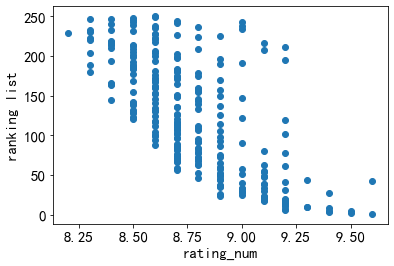

In [52]:
plt.scatter(df['rating_num'], df['num']) #绘制散点图
plt.xlabel('rating_num')    #x轴标签
plt.ylabel('ranking list')  #y轴标签
plt.show()

**结果：**
- 排名越靠前，即num越小，分数越高

**优化：**
- 但上图看着还是有些别扭，因为我们习惯了排名靠前的在 y 轴的上方
- 可以用 invert_yaxis() 函数来改变 y 轴标签的顺序
- 重构可视化显示

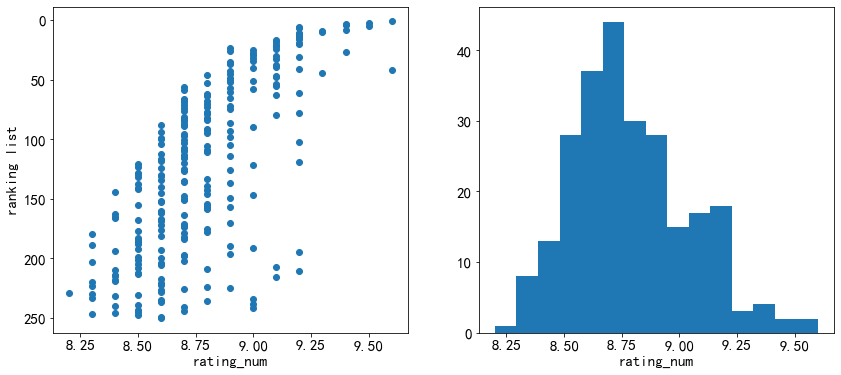

In [53]:
plt.figure(figsize=(14,6)) 
plt.subplot(1,2,1)
plt.scatter(df['rating_num'], df['num'])
plt.xlabel('rating_num')
plt.ylabel('ranking list')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.hist(df['rating_num'],bins = 15)
plt.xlabel('rating_num')
plt.show()

In [54]:
# 计算Pearson相关系数，显示相关性
df['num'].corr(df['rating_num'])

-0.6928655414458527

**结果分析：**

豆瓣评分大多是集中在 8.3 - 9.2 之间，随评分的升高，豆瓣Top250排名名次大致提前，Pearson相关系数为 --0.6929，呈强相关性。

### 4.2 排名与评论人数的关系-可视化分析 

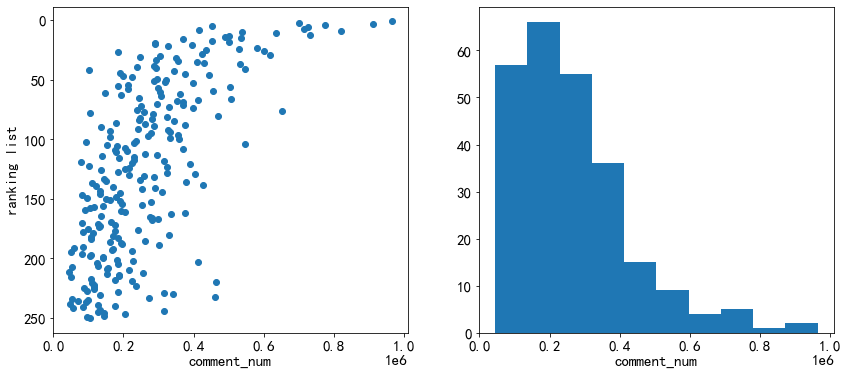

In [55]:
plt.figure(figsize=(14,6)) 
plt.subplot(1,2,1)
plt.scatter(df['comment_num'], df['num'])
plt.xlabel('comment_num')
plt.ylabel('ranking list')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.hist(df['comment_num'])
plt.xlabel('comment_num')
plt.show()

In [56]:
# 计算Pearson相关系数，显示相关性
df['num'].corr(df['comment_num'])

-0.6543641213113001

**结果分析：**

评价人数呈右偏分布，随评价人数的增多，豆瓣Top250排名名次有提前趋势，Pearson相关系数为-0.6544，呈强相关性。

### 4.3 排名与电影时长的关系-可视化分析

<Figure size 432x288 with 0 Axes>

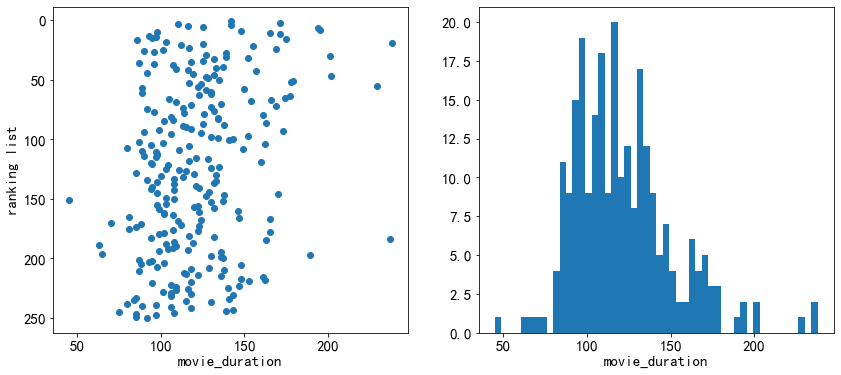

In [57]:
plt.figure(1)
plt.figure(figsize=(14,6)) 
plt.subplot(1,2,1)
plt.scatter(df['movie_duration'], df['num'])
plt.xlabel('movie_duration')
plt.ylabel('ranking list')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.hist(df['movie_duration'],bins = 50)
plt.xlabel('movie_duration')
plt.show()

In [58]:
# 计算Pearson相关系数，显示相关性
df['num'].corr(df['movie_duration'])

-0.2627522010562204

**结果分析：**

电影时长多数集中在 80-120 分钟之间，与豆瓣电影Top250之间关系不大，Pearson相关系数为 -0.2628，为弱相关性。

### 4.4 排名与上映年份的关系-可视化分析

<Figure size 432x288 with 0 Axes>

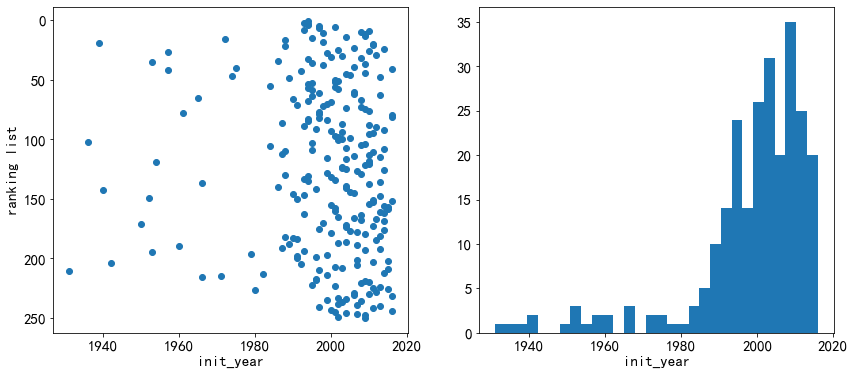

In [59]:
plt.figure(1)
plt.figure(figsize=(14,6)) 
plt.subplot(1,2,1)
plt.scatter(df['init_year'], df['num'])
plt.xlabel('init_year')
plt.ylabel('ranking list')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.hist(df['init_year'],bins = 30)
plt.xlabel('init_year')
plt.show()

In [60]:
# 计算Pearson相关系数，显示相关性
df['num'].corr(df['init_year'])

0.0886211958369098

**结果分析：**

上映年份多数其中在1990年之后，pearson相关系数为0.0886，与豆瓣电影Top250没有相关性。

### 4.5 国家/地区 电影top250排名统计-可视化分析

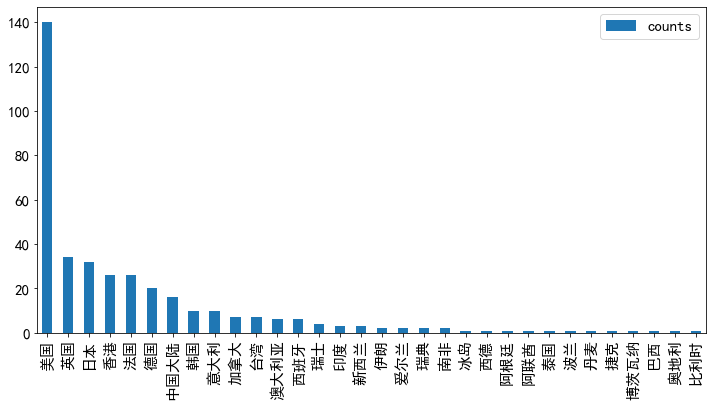

In [61]:
area_c.sort_values(by = 'counts',ascending = False).plot(kind ='bar', figsize = (12,6))
plt.show()

**结果分析：**

上榜电影中，美国电影数量最多，中国大陆排第七位。

### 4.6 电影语言排名统计-可视化分析

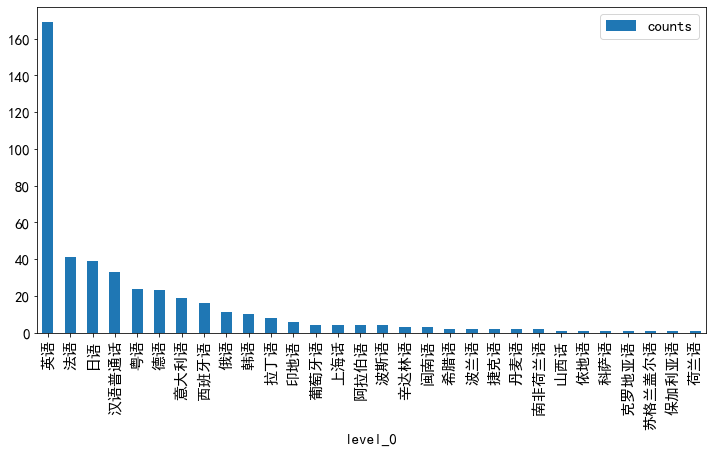

In [62]:
language_c.sort_values(by = 'counts',ascending = False)[:30].plot(kind ='bar', figsize = (12,6))
plt.show()

**结果分析：**

上榜电影使用最多的语言为英语，汉语普通话排第四位。

### 4.7 电影类型排名统计-可视化分析

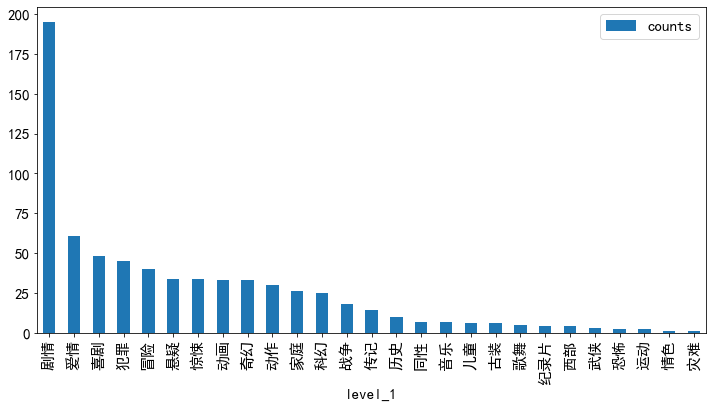

In [63]:
genre_c.sort_values(by = 'counts',ascending = False).plot(kind ='bar', figsize = (12,6))
plt.show()

**结果分析：**

最多的电影类型是剧情，其次是爱情。

### 4.8 电影电影标签热度词云统计-可视化分析

标签比较多，我们可以使用 wordcloud 这个Python包来制作词云。首先通过动态代码安装词云包wordcloud。

In [112]:
import pip
def install(package):
   pip.main(['install', package])

install('wordcloud')

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


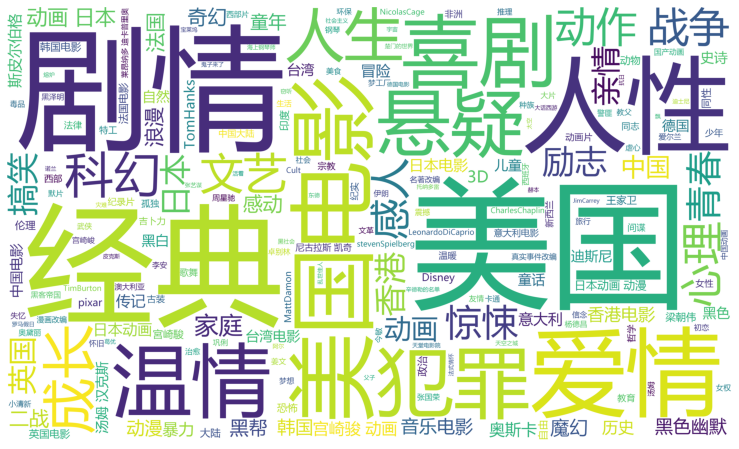

In [65]:
import wordcloud
from wordcloud import WordCloud

text = tags_split[['tags_1','tags_2','tags_3','tags_4','tags_5','tags_6','tags_7','tags_8']].to_string(header=False, index=False )
wordcloud = WordCloud(font_path='msyh.ttf', background_color='white' ,width=5000, height=3000, margin=2).generate(text)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 5 数据分析结论：
- 豆瓣电影Top250排行榜和电影评分及评论人数有强相关性，和上映时间无相关性。 
- 剧情、爱情、喜剧、犯罪、冒险类型的电影上榜较多。常用标签为“美国”、“剧情”、“经典”、“人性”、“爱情”。 
- 美国的电影最受欢迎，用的最多的语言是英语。 
- 上榜次数最多的导演是『克里斯托弗·诺兰 Christopher Nolan』和『宫崎骏 Hayao Miyazaki』，同为7次。 
- 上榜次数最多的主演是『张国荣 Leslie Cheung』，高达8次。 
- 片长和排名关系不大，多数集中在80-120之间。